In [1]:
import numpy as np
import pyreadr
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import textwrap

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report

from utils import pca, preprocess_data, plot_bar_importance, plot_confusion_matrix, one_step_compute_aic

In [2]:
path = "./gss_16.rda"

In [3]:
data = pyreadr.read_r(path)

In [4]:
df = data["gss16"]

# Phân loại tập dữ liệu thời gian sử dụng email khác null sử dụng AdaBoost

### Xử lý dữ liệu và phân tích thành phần chính

In [5]:
x, y, features_list, value_to_index = preprocess_data(df=df, remove_email_null=True, use_text_categorical=False, one_hot_encode=True)

U, reduced_x = pca(x=x, alpha=0.5)

reduced_x, x.shape

(array([[ 0.76516265, -1.16874744, -0.15042556,  0.18296905],
        [ 0.0738515 ,  0.73155778,  1.01875332,  0.28174455],
        [ 1.41275401, -0.15268227, -0.10413859, -0.70098884],
        ...,
        [ 1.26932849, -0.34444335, -0.12803762,  0.26231042],
        [ 0.61683124,  0.36932971, -1.26404303, -0.81219695],
        [ 1.47759915, -0.40272091,  0.23605025, -0.18099993]]),
 (1648, 46))

## Sử dụng feature thu được từ PCA

### Phân chia tập dữ liệu

In [6]:
X_train, X_test, y_train, y_test = train_test_split(reduced_x, y, test_size=0.4, random_state=42)

### Huấn luyện mô hình AdaBoost

In [7]:
ada_clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=3),
                             n_estimators=50,
                             algorithm="SAMME.R",
                             learning_rate=1.0)
# ada_clf = AdaBoostClassifier(base_estimator=LogisticRegression(multi_class='multinomial'),
#                              n_estimators=20,
#                              algorithm="SAMME.R",
#                              learning_rate=1.0)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                         max_depth=3))


### Kết quả huấn luyện mô hình

In [8]:
y_pred = ada_clf.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

                  precision    recall  f1-score   support

   Keeping house       0.13      0.16      0.14        58
           Other       0.00      0.00      0.00         8
         Retired       0.21      0.20      0.20       109
          School       0.00      0.00      0.00        14
Temp not working       0.00      0.00      0.00        15
Unempl, laid off       0.00      0.00      0.00        25
Working fulltime       0.53      0.55      0.54       351
Working parttime       0.11      0.14      0.12        80

        accuracy                           0.35       660
       macro avg       0.12      0.13      0.13       660
    weighted avg       0.34      0.35      0.35       660



### Tính AIC, BIC

In [9]:
aic = one_step_compute_aic(model=ada_clf, x_test=X_test, y_test=y_test)
bic = one_step_compute_aic(model=ada_clf, x_test=X_test, y_test=y_test, type="bic")

aic, bic

(2247.7281958064314, 2265.697155146513)

### Ma trận nhầm lẫn cho tập test

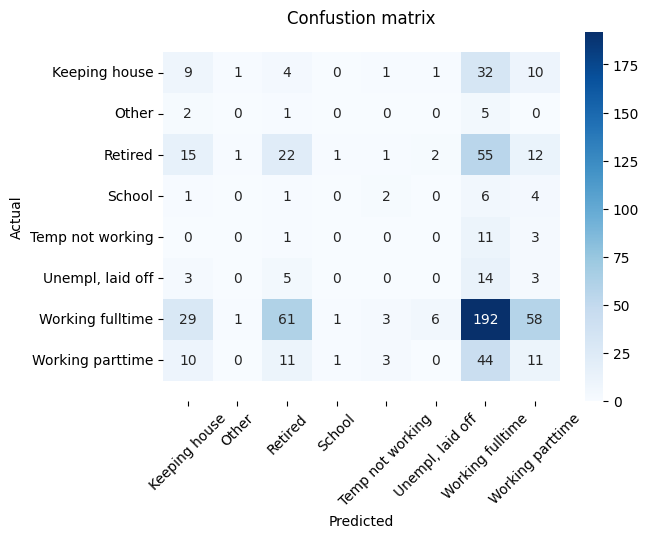

In [10]:
classes = ada_clf.classes_
plot_confusion_matrix(y_test, y_pred, classes)

### Từ điển ánh xạ chỉ số thành tên đặc trưng

In [11]:
index_to_features_list = dict(zip(range(len(features_list)), features_list))

index_to_features_list

{0: 'emailtotal',
 1: 'harass5_0',
 2: 'harass5_1',
 3: 'harass5_2',
 4: 'harass5_3',
 5: 'snapchat_0',
 6: 'snapchat_1',
 7: 'snapchat_2',
 8: 'instagrm_0',
 9: 'instagrm_1',
 10: 'instagrm_2',
 11: 'polviews_0',
 12: 'polviews_1',
 13: 'polviews_2',
 14: 'polviews_3',
 15: 'polviews_4',
 16: 'polviews_5',
 17: 'polviews_6',
 18: 'polviews_7',
 19: 'advfront_0',
 20: 'advfront_1',
 21: 'advfront_2',
 22: 'advfront_3',
 23: 'advfront_4',
 24: 'advfront_5',
 25: 'educ_0',
 26: 'educ_1',
 27: 'educ_2',
 28: 'educ_3',
 29: 'educ_4',
 30: 'educ_5',
 31: 'educ_6',
 32: 'educ_7',
 33: 'educ_8',
 34: 'educ_9',
 35: 'educ_10',
 36: 'educ_11',
 37: 'educ_12',
 38: 'educ_13',
 39: 'educ_14',
 40: 'educ_15',
 41: 'educ_16',
 42: 'educ_17',
 43: 'educ_18',
 44: 'educ_19',
 45: 'educ_20'}

### Từ điển biến chỉ số thành tên đặc trưng dễ đọc hơn

In [12]:
index_to_features_list_update = {}
for k, v in index_to_features_list.items():
    if v == "emailtotal":
        index_to_features_list_update[k] = v
    else:
        field, index = v.split("_")
        val_to_ind = {v: k for k, v in value_to_index[field].items()}
        #print(val_to_ind)
        if int(index) in val_to_ind:
            text_value = val_to_ind[int(index)]
            if isinstance(text_value, str):
                space_split = text_value.split(" ")
                if len(space_split) == 1:
                    index_to_features_list_update[k] = "{}_{}".format(field, space_split[0])
                else:
                    index_to_features_list_update[k] = "{}_{}".format(field, "_".join(space_split))
            else:
                index_to_features_list_update[k] = "{}_{}".format(field, int(text_value))
        else:
            index_to_features_list_update[k] = "{}_{}".format(field, "Unknown")
index_to_features_list = index_to_features_list_update
index_to_features_list

{0: 'emailtotal',
 1: 'harass5_Unknown',
 2: 'harass5_Does_not_apply_(i_do_not_have_a_job/superior/co-worker)',
 3: 'harass5_No',
 4: 'harass5_Yes',
 5: 'snapchat_Unknown',
 6: 'snapchat_No',
 7: 'snapchat_Yes',
 8: 'instagrm_Unknown',
 9: 'instagrm_No',
 10: 'instagrm_Yes',
 11: 'polviews_Unknown',
 12: 'polviews_Extrmly_conservative',
 13: 'polviews_Conservative',
 14: 'polviews_Slghtly_conservative',
 15: 'polviews_Moderate',
 16: 'polviews_Slightly_liberal',
 17: 'polviews_Liberal',
 18: 'polviews_Extremely_liberal',
 19: 'advfront_Unknown',
 20: 'advfront_Strongly_disagree',
 21: 'advfront_Disagree',
 22: 'advfront_Dont_know',
 23: 'advfront_Agree',
 24: 'advfront_Strongly_agree',
 25: 'educ_0',
 26: 'educ_1',
 27: 'educ_2',
 28: 'educ_3',
 29: 'educ_4',
 30: 'educ_5',
 31: 'educ_6',
 32: 'educ_7',
 33: 'educ_8',
 34: 'educ_9',
 35: 'educ_10',
 36: 'educ_11',
 37: 'educ_12',
 38: 'educ_13',
 39: 'educ_14',
 40: 'educ_15',
 41: 'educ_16',
 42: 'educ_17',
 43: 'educ_18',
 44: 'educ_

### Tên các nhãn từ tập dữ liệu

In [13]:
# pseudo_label = np.unique(y)
# index_to_pseudo_label = dict(zip(range(len(pseudo_label)), pseudo_label))
# index_to_pseudo_label

pseudo_label = ada_clf.classes_
index_to_pseudo_label = dict(zip(range(len(pseudo_label)), pseudo_label))
index_to_pseudo_label

{0: 'Keeping house',
 1: 'Other',
 2: 'Retired',
 3: 'School',
 4: 'Temp not working',
 5: 'Unempl, laid off',
 6: 'Working fulltime',
 7: 'Working parttime'}

### Biến đổi weights của mô hình PCA thành weight tương ứng các đặc trưng ban đầu

In [14]:
original_importance = U.dot(ada_clf.feature_importances_)
ada_clf.feature_importances_

array([0.26305688, 0.22113478, 0.26302333, 0.25278502])

### Lấy k feature có trị tuyệt đối của weight cao nhất

In [15]:
top_k_features = 10

### Trọng số của các đặc trưng cao nhất tương ứng với từng nhãn

In [16]:
importance = dict(zip(np.vectorize(lambda x: index_to_features_list[x])(np.argsort(np.abs(original_importance))[::-1][:top_k_features]), np.round(original_importance[np.argsort(np.abs(original_importance))[::-1][:top_k_features]], 3)))

In [17]:
importance

{'emailtotal': (-0.351+0j),
 'harass5_Unknown': (0.164+0j),
 'advfront_Unknown': (-0.163+0j),
 'harass5_No': (-0.14+0j),
 'polviews_Moderate': (-0.128+0j),
 'advfront_Strongly_agree': (0.11+0j),
 'snapchat_No': (0.08+0j),
 'instagrm_No': (0.068+0j),
 'educ_12': (-0.055+0j),
 'polviews_Liberal': (0.044+0j)}

### Biểu đồ cột các weight của các đặc trưng tương ứng với từng lớp

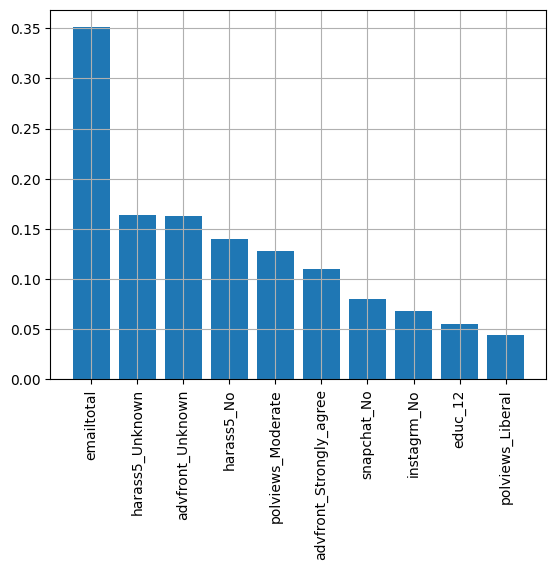

In [18]:
plt.bar(importance.keys(), np.abs(list(importance.values())))
plt.xticks(rotation=90)
plt.grid()
plt.show()

## Sử dụng feature gốc

### Phân chia tập dữ liệu

In [19]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)

### Huấn luyện mô hình AdaBoost

In [20]:
ada_clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=3),
                             n_estimators=50,
                             algorithm="SAMME.R",
                             learning_rate=1.0)
# ada_clf = AdaBoostClassifier(base_estimator=LogisticRegression(multi_class='multinomial'),
#                              n_estimators=20,
#                              algorithm="SAMME.R",
#                              learning_rate=1.0)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                         max_depth=3))

### Kết quả huấn luyện mô hình

In [21]:
y_pred = ada_clf.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

                  precision    recall  f1-score   support

   Keeping house       0.11      0.12      0.11        58
           Other       0.00      0.00      0.00         8
         Retired       0.23      0.20      0.21       109
          School       0.05      0.07      0.06        14
Temp not working       0.00      0.00      0.00        15
Unempl, laid off       0.00      0.00      0.00        25
Working fulltime       0.56      0.55      0.55       351
Working parttime       0.15      0.20      0.17        80

        accuracy                           0.36       660
       macro avg       0.14      0.14      0.14       660
    weighted avg       0.36      0.36      0.36       660



### Tính AIC, BIC


In [22]:
aic = one_step_compute_aic(model=ada_clf, x_test=X_test, y_test=y_test)
bic = one_step_compute_aic(model=ada_clf, x_test=X_test, y_test=y_test, type="bic")

aic, bic

(2388.2048256001403, 2594.847858011082)

### Ma trận nhầm lẫn cho tập test

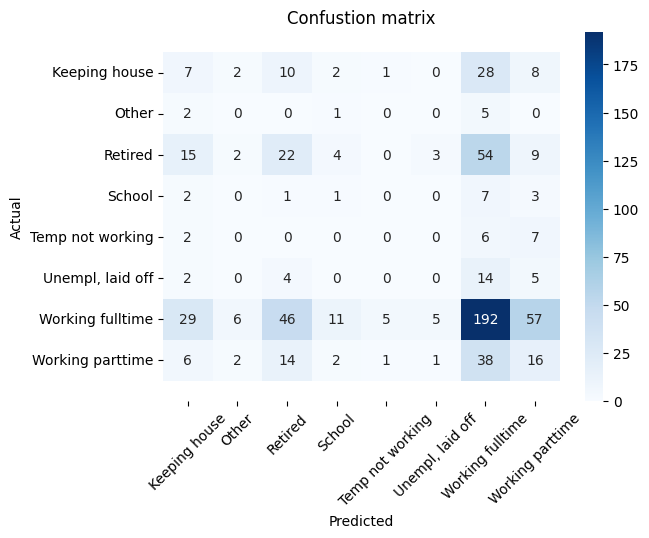

In [23]:
classes = ada_clf.classes_
plot_confusion_matrix(y_test, y_pred, classes)

### weight tương ứng các đặc trưng

In [24]:
original_importance = ada_clf.feature_importances_
original_importance

array([0.31738857, 0.00910741, 0.00684689, 0.0067972 , 0.00235755,
       0.00419303, 0.02824498, 0.02422482, 0.00449777, 0.01791387,
       0.02777803, 0.00917163, 0.01166053, 0.02230255, 0.02285159,
       0.04198218, 0.01731921, 0.05827036, 0.01312699, 0.01125979,
       0.00216514, 0.01156115, 0.01367022, 0.04722854, 0.04307236,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00403631, 0.00756735,
       0.01504785, 0.01231561, 0.04732564, 0.01847974, 0.04663706,
       0.02965683, 0.03152156, 0.00387556, 0.0035952 , 0.        ,
       0.00494896])

### Trọng số của các đặc trưng cao nhất tương ứng với từng nhãn giả

In [25]:
importance = dict(zip(np.vectorize(lambda x: index_to_features_list[x])(np.argsort(np.abs(original_importance))[::-1][:top_k_features]), np.round(original_importance[np.argsort(np.abs(original_importance))[::-1][:top_k_features]], 3)))

In [26]:
importance

{'emailtotal': 0.317,
 'polviews_Liberal': 0.058,
 'educ_12': 0.047,
 'advfront_Agree': 0.047,
 'educ_14': 0.047,
 'advfront_Strongly_agree': 0.043,
 'polviews_Moderate': 0.042,
 'educ_16': 0.032,
 'educ_15': 0.03,
 'snapchat_No': 0.028}

### Biểu đồ cột các weight của các đặc trưng tương ứng với từng lớp

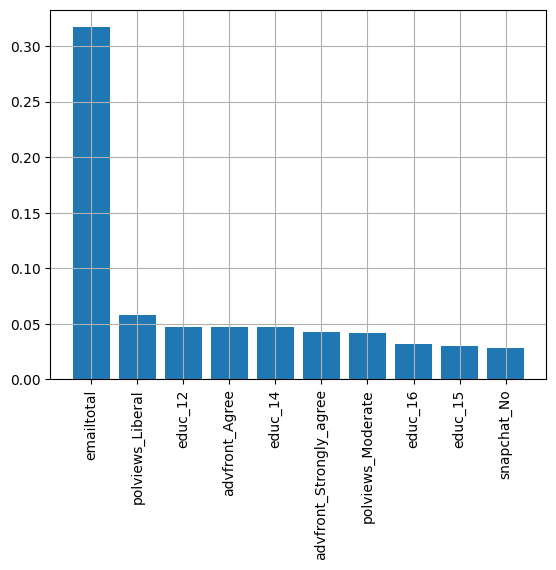

In [27]:
plt.bar(importance.keys(), np.abs(list(importance.values())))
plt.xticks(rotation=90)
plt.grid()
plt.show()

# Phân loại tập dữ liệu với email là null sử dụng AdaBoost

## Sử dụng feature thu được từ PCA

### Biến đổi dữ liệu và phân tích thành phần chính

In [28]:
x, y, features_list, value_to_index= preprocess_data(df=df, remove_email_null=False, use_text_categorical=False, one_hot_encode=True)

U, reduced_x = pca(x=x, alpha=0.4)

reduced_x, x.shape

(array([[ 1.30435   ,  0.46552921,  0.28922308],
        [ 0.60632419,  1.35262702, -0.48602664],
        [ 0.5626903 ,  1.33346182, -0.48373106],
        ...,
        [-0.64536006,  1.17042439,  0.69260063],
        [-0.68966536,  1.249954  ,  0.62442762],
        [ 1.3486553 ,  0.38599959,  0.35739608]]),
 (1210, 45))

### Phân chia tập dữ liệu

In [29]:
X_train, X_test, y_train, y_test = train_test_split(reduced_x, y, test_size=0.4, random_state=42)

### Huấn luyện mô hình AdaBoost

In [30]:
ada_clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=3),
                             n_estimators=50,
                             algorithm="SAMME.R",
                             learning_rate=1.0)
# ada_clf = AdaBoostClassifier(base_estimator=LogisticRegression(multi_class='multinomial'),
#                              n_estimators=20,
#                              algorithm="SAMME.R",
#                              learning_rate=1.0)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                         max_depth=3))

### Kết quả huấn luyện mô hình

In [31]:
y_pred = ada_clf.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

                  precision    recall  f1-score   support

   Keeping house       0.10      0.15      0.12        55
           Other       0.05      0.04      0.04        23
         Retired       0.32      0.36      0.34       113
          School       0.00      0.00      0.00        13
Temp not working       0.00      0.00      0.00         8
Unempl, laid off       0.06      0.05      0.06        19
Working fulltime       0.46      0.42      0.44       198
Working parttime       0.14      0.13      0.13        55

        accuracy                           0.29       484
       macro avg       0.14      0.14      0.14       484
    weighted avg       0.29      0.29      0.29       484



c:\Users\Thanh_Tuyet\.conda\envs\pytorch_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Thanh_Tuyet\.conda\envs\pytorch_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Thanh_Tuyet\.conda\envs\pytorch_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

### Tính AIC, BIC

In [32]:
aic = one_step_compute_aic(model=ada_clf, x_test=X_test, y_test=y_test)
bic = one_step_compute_aic(model=ada_clf, x_test=X_test, y_test=y_test, type="bic")

aic, bic

(1897.1958548275495, 1909.7421095476993)

### Ma trận nhầm lẫn cho tập test

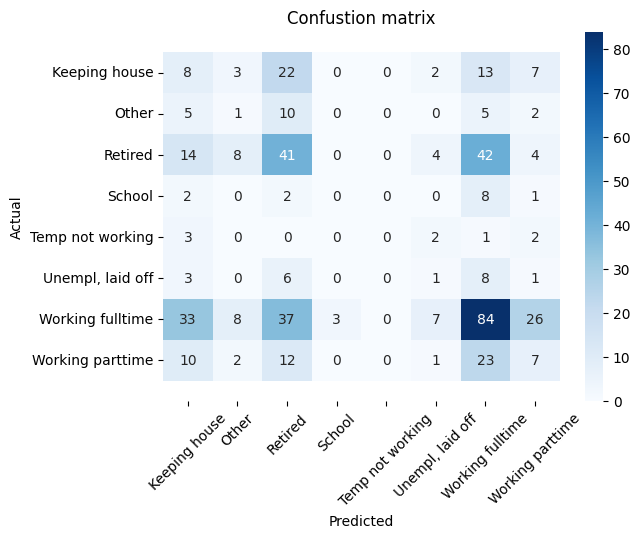

In [33]:
classes = ada_clf.classes_
plot_confusion_matrix(y_test, y_pred, classes)

### Từ điển ánh xạ chỉ số thành tên đặc trưng

In [34]:
index_to_features_list = dict(zip(range(len(features_list)), features_list))

index_to_features_list

{0: 'harass5_0',
 1: 'harass5_1',
 2: 'harass5_2',
 3: 'harass5_3',
 4: 'snapchat_0',
 5: 'snapchat_1',
 6: 'snapchat_2',
 7: 'instagrm_0',
 8: 'instagrm_1',
 9: 'instagrm_2',
 10: 'polviews_0',
 11: 'polviews_1',
 12: 'polviews_2',
 13: 'polviews_3',
 14: 'polviews_4',
 15: 'polviews_5',
 16: 'polviews_6',
 17: 'polviews_7',
 18: 'advfront_0',
 19: 'advfront_1',
 20: 'advfront_2',
 21: 'advfront_3',
 22: 'advfront_4',
 23: 'advfront_5',
 24: 'educ_0',
 25: 'educ_1',
 26: 'educ_2',
 27: 'educ_3',
 28: 'educ_4',
 29: 'educ_5',
 30: 'educ_6',
 31: 'educ_7',
 32: 'educ_8',
 33: 'educ_9',
 34: 'educ_10',
 35: 'educ_11',
 36: 'educ_12',
 37: 'educ_13',
 38: 'educ_14',
 39: 'educ_15',
 40: 'educ_16',
 41: 'educ_17',
 42: 'educ_18',
 43: 'educ_19',
 44: 'educ_20'}

### Từ điển biến chỉ số thành tên đặc trưng dễ đọc hơn

In [35]:
index_to_features_list_update = {}
for k, v in index_to_features_list.items():
    if v == "emailtotal":
        index_to_features_list_update[k] = v
    else:
        field, index = v.split("_")
        val_to_ind = {v: k for k, v in value_to_index[field].items()}
        #print(val_to_ind)
        if int(index) in val_to_ind:
            text_value = val_to_ind[int(index)]
            if isinstance(text_value, str):
                space_split = text_value.split(" ")
                if len(space_split) == 1:
                    index_to_features_list_update[k] = "{}_{}".format(field, space_split[0])
                else:
                    index_to_features_list_update[k] = "{}_{}".format(field, "_".join(space_split))
            else:
                index_to_features_list_update[k] = "{}_{}".format(field, int(text_value))
        else:
            index_to_features_list_update[k] = "{}_{}".format(field, "Unknown")
index_to_features_list = index_to_features_list_update
index_to_features_list

{0: 'harass5_Unknown',
 1: 'harass5_Does_not_apply_(i_do_not_have_a_job/superior/co-worker)',
 2: 'harass5_No',
 3: 'harass5_Yes',
 4: 'snapchat_Unknown',
 5: 'snapchat_No',
 6: 'snapchat_Yes',
 7: 'instagrm_Unknown',
 8: 'instagrm_No',
 9: 'instagrm_Yes',
 10: 'polviews_Unknown',
 11: 'polviews_Extrmly_conservative',
 12: 'polviews_Conservative',
 13: 'polviews_Slghtly_conservative',
 14: 'polviews_Moderate',
 15: 'polviews_Slightly_liberal',
 16: 'polviews_Liberal',
 17: 'polviews_Extremely_liberal',
 18: 'advfront_Unknown',
 19: 'advfront_Strongly_disagree',
 20: 'advfront_Disagree',
 21: 'advfront_Dont_know',
 22: 'advfront_Agree',
 23: 'advfront_Strongly_agree',
 24: 'educ_0',
 25: 'educ_1',
 26: 'educ_2',
 27: 'educ_3',
 28: 'educ_4',
 29: 'educ_5',
 30: 'educ_6',
 31: 'educ_7',
 32: 'educ_8',
 33: 'educ_9',
 34: 'educ_10',
 35: 'educ_11',
 36: 'educ_12',
 37: 'educ_13',
 38: 'educ_14',
 39: 'educ_15',
 40: 'educ_16',
 41: 'educ_17',
 42: 'educ_18',
 43: 'educ_19',
 44: 'educ_20'

### weight tương ứng các đặc trưng

In [36]:
original_importance = U.dot(ada_clf.feature_importances_)
ada_clf.feature_importances_

c:\Users\Thanh_Tuyet\.conda\envs\pytorch_tensorflow\lib\site-packages\sklearn\tree\_classes.py:666: RuntimeWarning: invalid value encountered in true_divide
  return self.tree_.compute_feature_importances()


array([0.34238574, 0.32476694,        nan])

## Sử dụng feature gốc

### Phân chia tập dữ liệu

In [37]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)

### Huấn luyện mô hình AdaBoost

In [38]:
ada_clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=3),
                             n_estimators=50,
                             algorithm="SAMME.R",
                             learning_rate=1.0)
# ada_clf = AdaBoostClassifier(base_estimator=LogisticRegression(multi_class='multinomial'),
#                              n_estimators=20,
#                              algorithm="SAMME.R",
#                              learning_rate=1.0)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                         max_depth=3))

### Kết quả huấn luyện mô hình

In [39]:
y_pred = ada_clf.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

                  precision    recall  f1-score   support

   Keeping house       0.10      0.11      0.11        55
           Other       0.04      0.04      0.04        23
         Retired       0.37      0.50      0.42       113
          School       0.05      0.08      0.06        13
Temp not working       0.00      0.00      0.00         8
Unempl, laid off       0.08      0.05      0.06        19
Working fulltime       0.51      0.46      0.48       198
Working parttime       0.09      0.05      0.07        55

        accuracy                           0.33       484
       macro avg       0.16      0.16      0.16       484
    weighted avg       0.32      0.33      0.32       484



### Tính AIC, BIC

In [40]:
aic = one_step_compute_aic(model=ada_clf, x_test=X_test, y_test=y_test)
bic = one_step_compute_aic(model=ada_clf, x_test=X_test, y_test=y_test, type="bic")

aic, bic

(1952.385561830628, 2140.5793826328763)

### Ma trận nhầm lẫn cho tập test

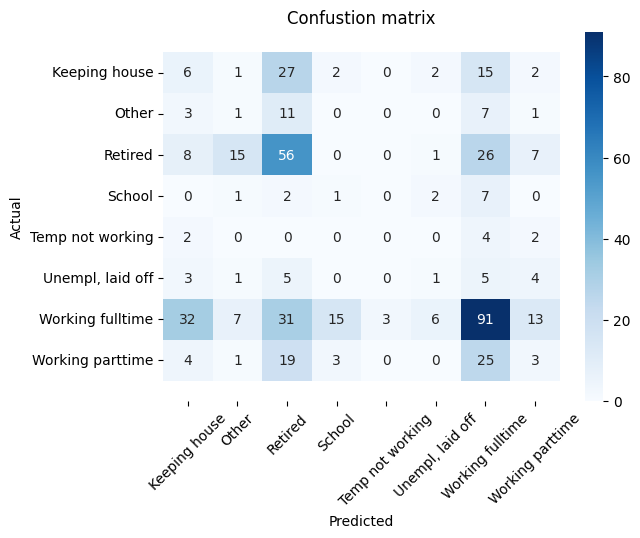

In [41]:
classes = ada_clf.classes_
plot_confusion_matrix(y_test, y_pred, classes)

### weight tương ứng các đặc trưng

In [42]:
original_importance = ada_clf.feature_importances_
original_importance

array([3.26537073e-03, 4.67870708e-02, 2.00357906e-02, 2.89818696e-02,
       3.53077278e-02, 7.92054637e-02, 9.80007300e-02, 2.04638361e-02,
       2.99638890e-02, 2.61105124e-03, 3.31482469e-03, 1.01844608e-03,
       1.17157189e-02, 1.87267376e-02, 6.57101738e-02, 1.46187183e-03,
       2.77670072e-04, 1.85484305e-03, 2.37047316e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.99136887e-07,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 5.67142462e-03, 2.04682851e-03,
       5.56949060e-03, 4.43383293e-03, 1.13366934e-02, 4.10584604e-03,
       1.42973622e-01, 2.64819740e-02, 1.13124829e-01, 5.51994766e-03,
       1.40234868e-01, 3.05840893e-02, 1.71322290e-02, 8.73325753e-03,
       1.09773104e-02])

### Trọng số của các đặc trưng cao nhất tương ứng với từng nhãn

In [43]:
importance = dict(zip(np.vectorize(lambda x: index_to_features_list[x])(np.argsort(np.abs(original_importance))[::-1][:top_k_features]), np.round(original_importance[np.argsort(np.abs(original_importance))[::-1][:top_k_features]], 3)))

In [44]:
importance

{'educ_12': 0.143,
 'educ_16': 0.14,
 'educ_14': 0.113,
 'snapchat_Yes': 0.098,
 'snapchat_No': 0.079,
 'polviews_Moderate': 0.066,
 'harass5_Does_not_apply_(i_do_not_have_a_job/superior/co-worker)': 0.047,
 'snapchat_Unknown': 0.035,
 'educ_17': 0.031,
 'instagrm_No': 0.03}

### Biểu đồ cột các weight của các đặc trưng

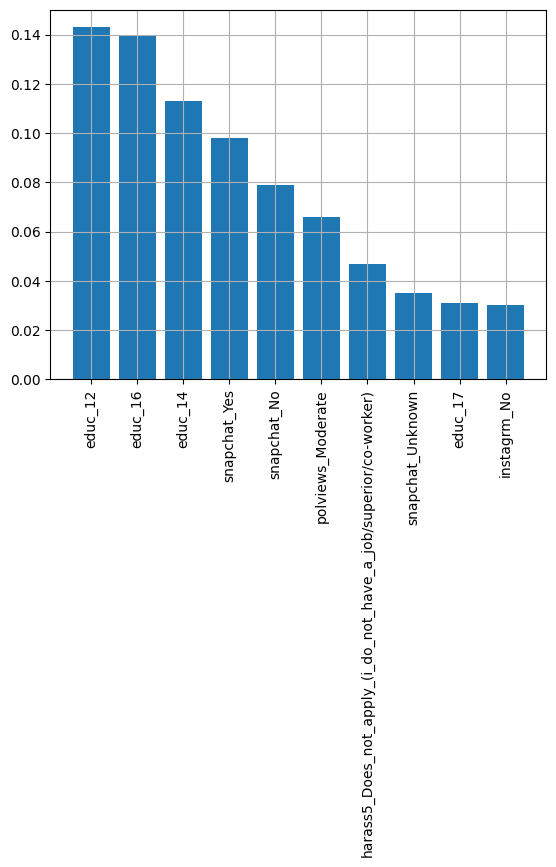

In [45]:
plt.bar(importance.keys(), np.abs(list(importance.values())))
plt.xticks(rotation=90)
plt.grid()
plt.show()